In [1]:
import os
import io

import numpy as np
import pandas as pd
import scipy.io as sio
from google.cloud import storage


/Users/tanya/.pyenv/versions/3.10.6/envs/inkling/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# Configure which .mat object to load (defaults to S001)
mat_object = os.getenv('GCS_OBJECT_MAIN', 'Wearable SSVEP Dataset/S001.mat')
subject_id = os.path.splitext(os.path.basename(mat_object))[0]

client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))

print(f'Loading {mat_object} for subject {subject_id}')
blob = bucket.blob(mat_object)
data_bytes = blob.download_as_bytes()
mat = sio.loadmat(io.BytesIO(data_bytes))

data = mat['data']  # expected shape (channels, time, electrode, block, target)
print('Loaded data shape:', data.shape)

Loading Wearable SSVEP Dataset/S001.mat for subject S001
Loaded data shape: (8, 710, 2, 10, 12)


In [3]:
# Build epoch-level dataframe for a single subject (one row per electrode x block x target)
expected_shape = (8, 710, 2, 10, 12)
if data.shape != expected_shape:
    raise ValueError(f'Unexpected data shape {data.shape}, expected {expected_shape}')

rows = []
electrode_map = {0: 'wet', 1: 'dry'}

for e_idx in range(data.shape[2]):
    for b_idx in range(data.shape[3]):
        for t_idx in range(data.shape[4]):
            rows.append(
                {
                    'subject': subject_id,
                    'electrode': electrode_map.get(e_idx, str(e_idx)),
                    'block': b_idx + 1,   # 1-based
                    'target': t_idx + 1,  # 1-based
                    'signal': data[:, :, e_idx, b_idx, t_idx],  # shape (8, 710)
                }
            )

all_epochs = pd.DataFrame(rows)
print('DataFrame shape:', all_epochs.shape)
print(all_epochs.head())
print('Electrode counts:')
print(all_epochs['electrode'].value_counts())

DataFrame shape: (240, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Electrode counts:
electrode
wet    120
dry    120
Name: count, dtype: int64


In [4]:
# Build full multi-subject epoch DataFrame (102 subjects x 240 epochs)

import re


def load_mat_from_gcs(filepath):
    """Download a .mat from GCS and return the 'data' array."""
    client = storage.Client.from_service_account_json(
        os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    )
    bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
    blob = bucket.blob(filepath)
    bytes_data = blob.download_as_bytes()
    mat = sio.loadmat(io.BytesIO(bytes_data))
    if 'data' not in mat:
        raise KeyError(f"'data' variable missing in {filepath}")
    arr = mat['data']
    if arr.shape != (8, 710, 2, 10, 12):
        raise ValueError(f"Unexpected shape {arr.shape} in {filepath}")
    return arr


def build_subject_df(subject_id, data):
    """Convert one subject's 5-D array into a 240-row DataFrame."""
    expected = (8, 710, 2, 10, 12)
    if data.shape != expected:
        raise ValueError(f"Unexpected shape {data.shape}, expected {expected}")

    rows = []
    for e_idx in range(2):
        for b_idx in range(10):
            for t_idx in range(12):
                rows.append(
                    {
                        'subject': subject_id,
                        'electrode': 'wet' if e_idx == 0 else 'dry',
                        'block': b_idx + 1,
                        'target': t_idx + 1,
                        'signal': data[:, :, e_idx, b_idx, t_idx],
                    }
                )
    return pd.DataFrame(rows)


# List all subject .mat files (skip non-subject files like Impedance.mat)
client = storage.Client.from_service_account_json(
    os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
)
bucket = client.bucket(os.getenv('GCP_BUCKET_NAME'))
prefix = 'Wearable SSVEP Dataset/'
mat_files = []
for b in bucket.list_blobs(prefix=prefix):
    name = b.name
    base = os.path.basename(name)
    if not base.endswith('.mat'):
        continue
    if not re.match(r'S\d+\.mat$', base):
        continue  # skip non-subject files (e.g., Impedance.mat)
    mat_files.append(name)
mat_files.sort()
print(f'Found {len(mat_files)} subject .mat files')

# Build combined DataFrame
all_subject_dfs = []
for fp in mat_files:
    subject_id = os.path.splitext(os.path.basename(fp))[0]
    try:
        data_arr = load_mat_from_gcs(fp)
    except (KeyError, ValueError) as exc:
        print(f'Skipping {fp}: {exc}')
        continue
    df_subj = build_subject_df(subject_id, data_arr)
    all_subject_dfs.append(df_subj)

full_df = pd.concat(all_subject_dfs, ignore_index=True)

# Summaries
print('full_df shape:', full_df.shape)
print(full_df.head())
print('Subject counts:')
print(full_df['subject'].value_counts())
print('Electrode counts:')
print(full_df['electrode'].value_counts())


Found 102 subject .mat files
full_df shape: (24480, 5)
  subject electrode  block  target  \
0    S001       wet      1       1   
1    S001       wet      1       2   
2    S001       wet      1       3   
3    S001       wet      1       4   
4    S001       wet      1       5   

                                              signal  
0  [[-52325.52005800724, -53157.22841961553, -554...  
1  [[-56806.91044371786, -58819.819022406286, -60...  
2  [[-58424.81901793594, -57290.15513003797, -551...  
3  [[-59719.47668310861, -61462.01857698074, -609...  
4  [[-57667.36314698238, -60079.16093344456, -608...  
Subject counts:
subject
S001    240
S065    240
S075    240
S074    240
S073    240
       ... 
S032    240
S031    240
S030    240
S029    240
S102    240
Name: count, Length: 102, dtype: int64
Electrode counts:
electrode
wet    12240
dry    12240
Name: count, dtype: int64


In [5]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

FS = 250  # sampling rate in Hz (given by the dataset paper)


def bandpass(epoch, low=8, high=90, fs=FS, order=4):
    """
    Band-pass filter: keep only frequencies between `low` and `high` Hz.
    epoch: array of shape (n_channels, n_samples)
    """
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, epoch, axis=-1)


def notch(epoch, freq=50, fs=FS, q=30):
    """
    Notch filter: remove a narrow band around `freq` Hz (e.g. 50 Hz mains noise).
    """
    nyq = fs / 2
    w0 = freq / nyq
    b, a = iirnotch(w0, Q=q)
    return filtfilt(b, a, epoch, axis=-1)


def preprocess_epoch(epoch_raw):
    """
    Full preprocessing for a single trial.
    Input:  epoch_raw shape (8, 710)
    Output: preprocessed epoch shape (8, 500)
    """
    # Always work in float64 to avoid numerical weirdness
    epoch = epoch_raw.astype(np.float64)

    # 1) Band-pass 8–90 Hz: keep SSVEP fundamentals + harmonics, remove drifts & ultra-high noise
    epoch = bandpass(epoch, low=8, high=90, fs=FS, order=4)

    # 2) Notch 50 & 100 Hz: remove mains electrical hum and its first harmonic
    epoch = notch(epoch, freq=50, fs=FS, q=30)
    epoch = notch(epoch, freq=100, fs=FS, q=30)

    # 3) Baseline correction using -0.5s to 0s (first 125 samples at 250 Hz)
    baseline = epoch[:, :125].mean(axis=-1, keepdims=True)
    epoch = epoch - baseline

    # 4) Trim to main SSVEP window.
    #    0.5s pre + ~0.14s visual delay => start ~0.64s after trial onset: sample 160
    #    2s of stimulation => 500 samples => 160:660
    epoch = epoch[:, 160:660]  # shape (8, 500)

    # 5) Per-epoch, per-channel z-score:
    #    make each channel have mean 0 and std 1 in this epoch, so scales are comparable.
    mean = epoch.mean(axis=-1, keepdims=True)
    std = epoch.std(axis=-1, keepdims=True) + 1e-8
    epoch = (epoch - mean) / std

    return epoch


In [6]:
full_df['signal_pp'] = full_df['signal'].apply(preprocess_epoch)
pp_full_df = full_df
pp_full_df

,subject,electrode,block,target,signal,signal_pp
0,S001,wet,1,1,"[[-52325.52005800724, -53157.22841961553, -554...","[[1.70329534663277, 1.005246832872975, -0.6968..."
1,S001,wet,1,2,"[[-56806.91044371786, -58819.819022406286, -60...","[[2.1173829193890454, 0.23705557026530585, -1...."
2,S001,wet,1,3,"[[-58424.81901793594, -57290.15513003797, -551...","[[-3.4062449388976734, -0.6271521744047096, 3...."
3,S001,wet,1,4,"[[-59719.47668310861, -61462.01857698074, -609...","[[0.2641990410447794, -0.39355795229029994, -0..."
4,S001,wet,1,5,"[[-57667.36314698238, -60079.16093344456, -608...","[[0.633041792724005, -0.27745217316847137, -0...."
...,...,...,...,...,...,...
24475,S102,dry,10,8,"[[10971.978960751234, 11017.442406263495, 1104...","[[-1.371439566731729, -1.0397680194580703, -2...."
24476,S102,dry,10,9,"[[11072.293583887433, 11040.330591221487, 1100...","[[0.19956229808600792, 0.5625620121231513, -1...."
24477,S102,dry,10,10,"[[11305.064636770763, 11329.919775123582, 1130...","[[-0.25180437619401635, -0.1536912581035672, 0..."
24478,S102,dry,10,11,"[[11089.77264700965, 11050.031247736886, 11049...","[[1.9501752759802595, 1.570491017693854, 1.201..."


In [7]:
# Use only dry-electrode trials
mask = (pp_full_df['electrode'] == 'dry')
df_dry = pp_full_df.loc[mask].reset_index(drop=True)

# Stack preprocessed signals into a big 3D array: (n_trials, n_channels, n_samples)
X = np.stack(df_dry['signal_pp'].values)   # shape (N_trials, 8, 500)

# Targets: 1..12 in the dataset; convert to 0..11 for indexing convenience
y = df_dry['target'].values - 1

# Keep subject labels for optional per-subject analysis
subjects = df_dry['subject'].values

print("X shape:", X.shape)   # (N_dry_trials, 8, 500)
print("y shape:", y.shape, "unique targets:", np.unique(y))

X shape: (12240, 8, 500)
y shape: (12240,) unique targets: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [8]:

FS = 250          # sampling rate (Hz)
N_HARMONICS = 5   # number of harmonics to use in references

# Target-wise frequency & phase from stimulation_information.pdf -----

FREQ_PER_TARGET = np.array([
    9.25,   # target 1  → '1'
    11.25,  # target 2  → '2'
    13.25,  # target 3  → '3'
    9.75,   # target 4  → '4'
    11.75,  # target 5  → '5'
    13.75,  # target 6  → '6'
    10.25,  # target 7  → '7'
    12.25,  # target 8  → '8'
    14.25,  # target 9  → '9'
    10.75,  # target 10 → '0'
    12.75,  # target 11 → '*'
    14.75   # target 12 → '#'
], dtype=float)

PHASE_PER_TARGET = np.array([
    0.0 * np.pi,  # target 1
    0.0 * np.pi,  # target 2
    0.0 * np.pi,  # target 3
    0.5 * np.pi,  # target 4
    0.5 * np.pi,  # target 5
    0.5 * np.pi,  # target 6
    1.0 * np.pi,  # target 7
    1.0 * np.pi,  # target 8
    1.0 * np.pi,  # target 9
    1.5 * np.pi,  # target 10
    1.5 * np.pi,  # target 11
    1.5 * np.pi   # target 12
], dtype=float)

In [9]:
def make_ref_signals_targetwise(freqs, phases, n_samples, fs=FS, n_harmonics=N_HARMONICS):
    """
    Build one reference matrix per target using that target's frequency AND phase.

    Returns: list of length n_targets
        refs[k] has shape (2 * n_harmonics, n_samples)
    """
    t = np.arange(n_samples) / fs
    refs = []

    for f, phi in zip(freqs, phases):
        components = []
        for h in range(1, n_harmonics + 1):
            # sin and cos with correct phase offset
            components.append(np.sin(2 * np.pi * h * f * t + phi))
            components.append(np.cos(2 * np.pi * h * f * t + phi))
        Y = np.stack(components, axis=0)  # (2 * n_harmonics, n_samples)
        refs.append(Y)

    return refs

In [10]:
from scipy.linalg import svd
from sklearn.model_selection import StratifiedKFold

# Filter-bank definition: five contiguous 8 Hz bands from 8–50 Hz
FILTER_BANKS = [
    (8, 16),
    (16, 24),
    (24, 32),
    (32, 40),
    (40, 50),
]


def cca_on_trial(X_trial, Y_ref, reg=1e-6):
    """Return the top canonical correlation between one trial and one reference."""
    # Center each channel/component
    Xc = X_trial - X_trial.mean(axis=1, keepdims=True)
    Yc = Y_ref - Y_ref.mean(axis=1, keepdims=True)
    n = Xc.shape[1]

    # Covariance + small ridge for stability
    Sxx = (Xc @ Xc.T) / (n - 1) + reg * np.eye(Xc.shape[0])
    Syy = (Yc @ Yc.T) / (n - 1) + reg * np.eye(Yc.shape[0])
    Sxy = (Xc @ Yc.T) / (n - 1)

    # Whitening transforms via eigen decomposition
    def inv_sqrt(mat):
        vals, vecs = np.linalg.eigh(mat)
        vals = np.clip(vals, reg, None)
        return vecs @ np.diag(1.0 / np.sqrt(vals)) @ vecs.T

    Wx = inv_sqrt(Sxx)
    Wy = inv_sqrt(Syy)

    # Solve CCA via SVD of the whitened cross-covariance
    K = Wx @ Sxy @ Wy
    _, s, _ = svd(K, full_matrices=False)
    return float(np.clip(s[0], 0.0, 1.0))


def fbcca_classify(X_trial, target_refs, filter_bank_params=FILTER_BANKS, fs=FS):
    """Classify one preprocessed trial using FBCCA and return the predicted target index."""
    rhos = []
    for band_idx, (f_low, f_high) in enumerate(filter_bank_params, start=1):
        # Band-specific filtering only (input is already preprocessed)
        trial_filt = bandpass(X_trial, low=f_low, high=f_high, fs=fs, order=4)
        trial_filt = notch(trial_filt, freq=50, fs=fs, q=30)
        trial_filt = notch(trial_filt, freq=100, fs=fs, q=30)

        # CCA against each target reference
        rho_per_target = [cca_on_trial(trial_filt, ref) for ref in target_refs]
        rhos.append(rho_per_target)

    rhos = np.asarray(rhos)  # shape (n_bands, n_targets)
    weights = np.array([(i ** -1.25) + 0.25 for i in range(1, len(filter_bank_params) + 1)])
    scores = (weights[:, None] * (rhos ** 2)).sum(axis=0)
    return int(np.argmax(scores))


# Build reference signals once using the full 500-sample window
# ref_signals = make_ref_signals_targetwise(FREQ_PER_TARGET, PHASE_PER_TARGET, n_samples=500, fs=FS)

# 5-fold stratified CV across all trials
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fold_acc = []

# for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
#    preds = [fbcca_classify(trial, ref_signals) for trial in X[test_idx]]
#    y_true = y[test_idx]
#    acc = (np.array(preds) == y_true).mean()
#    fold_acc.append(acc)
#    print(f'Fold {fold} accuracy: {acc:.4f} (n={len(test_idx)})')

# print(f'FBCCA 5-fold accuracy: mean={np.mean(fold_acc):.4f}, std={np.std(fold_acc):.4f}')


In [11]:
# Reference signals for the full window (500 samples)
ref_signals = make_ref_signals_targetwise(
    FREQ_PER_TARGET,
    PHASE_PER_TARGET,
    n_samples=500,
    fs=FS
)

In [12]:
# Split into train+val and test sets (80/20 stratified) used by BOTH models
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2025)
trainval_idx, test_idx = next(sss.split(X, y))

X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train+Val:", X_trainval.shape)
print("Test:", X_test.shape)


Train+Val: (9792, 8, 500)
Test: (2448, 8, 500)


In [13]:
fbcca_test_preds = [fbcca_classify(trial, ref_signals) for trial in X_test]
fbcca_test_acc = (np.array(fbcca_test_preds) == y_test).mean()

print(f"FBCCA test accuracy: {fbcca_test_acc:.4f}")

FBCCA test accuracy: 0.7594


In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -----------------------------
# Compact EEGNet-like CNN model
# -----------------------------
class EEGNet(nn.Module):
    def __init__(self, n_chans=8, n_samples=500, n_classes=12, dropout=0.5):
        super().__init__()
        self.n_chans = n_chans
        self.n_samples = n_samples

        self.conv_time = nn.Conv2d(1, 8, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.bn1 = nn.BatchNorm2d(8)

        # Depthwise convolution across channels
        self.depthwise = nn.Conv2d(8, 16, kernel_size=(n_chans, 1), groups=8, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(dropout)

        # Separable convolution (depthwise temporal + pointwise)
        self.separable = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=(1, 16), padding=(0, 8), groups=16, bias=False),
            nn.Conv2d(16, 16, kernel_size=(1, 1), bias=False),
        )
        self.bn3 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(dropout)

        # Compute final feature size after convolutions/pooling
        dummy = torch.zeros(1, 1, n_chans, n_samples)
        with torch.no_grad():
            feat = self._forward_features(dummy)
        self.classifier = nn.Linear(feat.shape[1], n_classes)

    def _forward_features(self, x):
        x = self.conv_time(x)
        x = self.bn1(x)
        x = F.elu(x)

        x = self.depthwise(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.separable(x)
        x = self.bn3(x)
        x = F.elu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        return x.flatten(start_dim=1)

    def forward(self, x):
        x = self._forward_features(x)
        return self.classifier(x)



# def train_eegnet_fold(X_train, y_train, X_test, y_test, epochs=15, batch_size=64, lr=1e-3, device='cpu'):
#     model = EEGNet(n_chans=X_train.shape[2], n_samples=X_train.shape[3], n_classes=len(np.unique(y))).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()

#     train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#     test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

#     for epoch in range(1, epochs + 1):
#         model.train()
#         running_loss = 0.0
#         for xb, yb in train_loader:
#             xb = xb.to(device)
#             yb = yb.to(device)
#             opt.zero_grad()
#             logits = model(xb)
#             loss = criterion(logits, yb)
#             loss.backward()
#             opt.step()
#             running_loss += loss.item() * xb.size(0)
#         if epoch % max(1, epochs // 5) == 0:
#             avg_loss = running_loss / len(train_loader.dataset)
#             print(f'Epoch {epoch:02d}/{epochs} - loss {avg_loss:.4f}')

#     # Evaluate
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for xb, yb in test_loader:
#             xb = xb.to(device)
#             yb = yb.to(device)
#             preds = model(xb).argmax(dim=1)
#             correct += (preds == yb).sum().item()
#             total += yb.numel()
#     return correct / total


# # -----------------------------
# # Cross-validation: FBCCA vs EEGNet
# # -----------------------------
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using device: {dev}')

# np.random.seed(42)
# torch.manual_seed(42)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# fbcca_acc = []
# eegnet_acc = []

# for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
#     print(f'Fold {fold}')
#     X_train = X[train_idx]
#     y_train = y[train_idx]
#     X_test = X[test_idx]
#     y_test = y[test_idx]

#     # FBCCA (no training)
#     fbcca_preds = [fbcca_classify(trial, ref_signals) for trial in X_test]
#     acc_fb = (np.array(fbcca_preds) == y_test).mean()
#     fbcca_acc.append(acc_fb)
#     print(f'FBCCA accuracy: {acc_fb:.4f}')

#     # EEGNet training (input shape: N x 1 x C x T)
#     X_train_torch = np.expand_dims(X_train, 1)
#     X_test_torch = np.expand_dims(X_test, 1)
#     acc_cnn = train_eegnet_fold(X_train_torch, y_train, X_test_torch, y_test, epochs=12, batch_size=64, lr=1e-3, device=dev)
#     eegnet_acc.append(acc_cnn)
#     print(f'EEGNet accuracy: {acc_cnn:.4f}')

# print('FBCCA  mean={:.4f} std={:.4f}'.format(np.mean(fbcca_acc), np.std(fbcca_acc)))
# print('EEGNet mean={:.4f} std={:.4f}'.format(np.mean(eegnet_acc), np.std(eegnet_acc)))

# # -----------------------------
# # Plot comparison
# # -----------------------------
# folds = np.arange(1, len(fbcca_acc) + 1)
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(folds, fbcca_acc, marker='o', label='FBCCA')
# plt.plot(folds, eegnet_acc, marker='s', label='EEGNet')
# plt.xlabel('Fold')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.title('Per-fold accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# bar_means = [np.mean(fbcca_acc), np.mean(eegnet_acc)]
# bar_stds = [np.std(fbcca_acc), np.std(eegnet_acc)]
# plt.bar(['FBCCA', 'EEGNet'], bar_means, yerr=bar_stds, capsize=5, color=['#4e79a7', '#f28e2b'])
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.title('Mean accuracy ± std')

# plt.tight_layout()
# plt.show()

In [15]:
from torch.utils.data import DataLoader, TensorDataset

def train_eegnet_with_history(X, y,
                              epochs=40,
                              batch_size=32,
                              lr=1e-3,
                              weight_decay=1e-3,
                              patience=6,
                              ckpt_path='eegnet_tuned.pth'):

    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2024)
    tr_idx, va_idx = next(sss.split(X, y))

    X_tr = np.expand_dims(X[tr_idx], 1)
    y_tr = y[tr_idx]
    X_va = np.expand_dims(X[va_idx], 1)
    y_va = y[va_idx]

    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_tr).float(), torch.from_numpy(y_tr)),
        batch_size=batch_size, shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_va).float(), torch.from_numpy(y_va)),
        batch_size=batch_size
    )

    model = EEGNet(n_chans=X.shape[1], n_samples=X.shape[2],
                   n_classes=len(np.unique(y))).to(dev)

    opt = torch.optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs)
    crit = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val = 0
    wait = 0

    for epoch in range(1, epochs + 1):
        model.train()
        loss_sum = correct = total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(dev), yb.to(dev)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

            loss_sum += loss.item() * xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            total += yb.numel()

        scheduler.step()
        train_loss = loss_sum / total
        train_acc = correct / total

        model.eval()
        loss_sum = correct = total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(dev), yb.to(dev)
                logits = model(xb)
                loss = crit(logits, yb)
                loss_sum += loss.item() * xb.size(0)
                correct += (logits.argmax(1) == yb).sum().item()
                total += yb.numel()

        val_loss = loss_sum / total
        val_acc = correct / total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d} | "
              f"train acc {train_acc:.3f} | "
              f"val acc {val_acc:.3f}")

        if val_acc > best_val:
            best_val = val_acc
            wait = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                break

    model.load_state_dict(torch.load(ckpt_path, map_location=dev))
    model.eval()
    return model, history

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 01 | train acc 0.172 | val acc 0.424
Epoch 02 | train acc 0.471 | val acc 0.611
Epoch 03 | train acc 0.593 | val acc 0.673
Epoch 04 | train acc 0.630 | val acc 0.712
Epoch 05 | train acc 0.655 | val acc 0.722
Epoch 06 | train acc 0.663 | val acc 0.726
Epoch 07 | train acc 0.678 | val acc 0.741
Epoch 08 | train acc 0.685 | val acc 0.745
Epoch 09 | train acc 0.683 | val acc 0.747
Epoch 10 | train acc 0.693 | val acc 0.756
Epoch 11 | train acc 0.695 | val acc 0.749
Epoch 12 | train acc 0.696 | val acc 0.759
Epoch 13 | train acc 0.702 | val acc 0.765
Epoch 14 | train acc 0.709 | val acc 0.765
Epoch 15 | train acc 0.706 | val acc 0.770
Epoch 16 | train acc 0.714 | val acc 0.755
Epoch 17 | train acc 0.707 | val acc 0.766
Epoch 18 | train acc 0.713 | val acc 0.767
Epoch 19 | train acc 0.714 | val acc 0.772
Epoch 20 | train acc 0.708 | val acc 0.776
Epoch 21 | train acc 0.713 | val acc 0.781
Epoch 22 | train acc 0.714 | val acc 0.765
Epoch 23 | train acc 0.717 | val acc 0.773
Epoch 24 | 

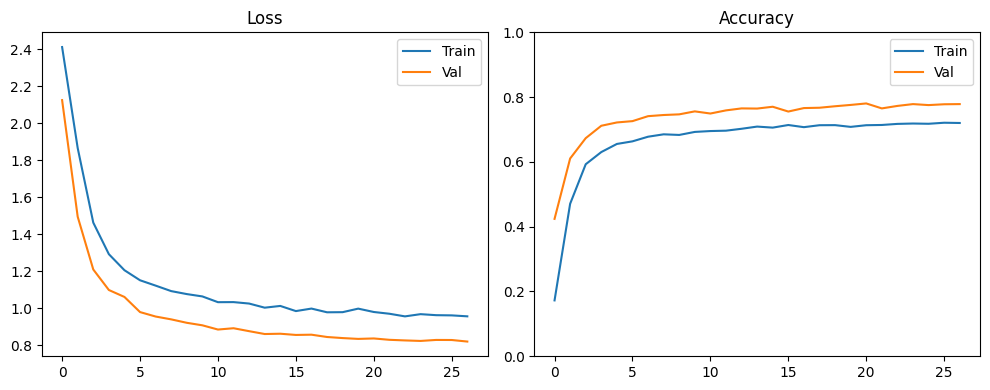

In [16]:
model, history = train_eegnet_with_history(X_trainval, y_trainval)

import matplotlib.pyplot as plt
import numpy as np

epochs = len(history['train_loss'])
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(range(epochs), history['train_loss'], label='Train')
plt.plot(range(epochs), history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(epochs), history['train_acc'], label='Train')
plt.plot(range(epochs), history['val_acc'], label='Val')
plt.title('Accuracy')
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()

Using device: cpu
FBCCA  test accuracy: 0.7594
EEGNet test accuracy: 0.7753


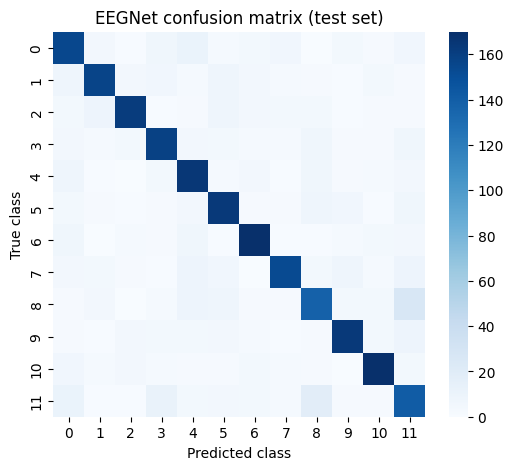

EEGNet classification report (per class):
              precision    recall  f1-score   support

           0      0.714     0.760     0.736       204
           1      0.822     0.770     0.795       204
           2      0.857     0.794     0.824       204
           3      0.779     0.779     0.779       204
           4      0.730     0.809     0.767       204
           5      0.756     0.804     0.779       204
           6      0.821     0.833     0.827       204
           7      0.841     0.750     0.793       204
           8      0.715     0.676     0.695       204
           9      0.832     0.804     0.818       204
          10      0.846     0.833     0.840       204
          11      0.629     0.691     0.659       204

    accuracy                          0.775      2448
   macro avg      0.779     0.775     0.776      2448
weighted avg      0.779     0.775     0.776      2448



In [17]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", dev)

# ---------- 1) FBCCA on the test set ----------
# (only run if you haven't already)
fbcca_test_preds = [fbcca_classify(trial, ref_signals) for trial in X_test]
fbcca_test_preds = np.array(fbcca_test_preds)
fbcca_test_acc = accuracy_score(y_test, fbcca_test_preds)
print(f"FBCCA  test accuracy: {fbcca_test_acc:.4f}")

# ---------- 2) EEGNet on the test set ----------
# X_test shape: (N_test, 8, 500) → add channel dim to get (N_test, 1, 8, 500)
X_test_t = torch.from_numpy(np.expand_dims(X_test, 1)).float().to(dev)
y_test_t = torch.from_numpy(y_test).long().to(dev)

model.to(dev)
model.eval()

all_preds = []
with torch.no_grad():
    for i in range(0, X_test_t.shape[0], 64):   # batch over test set
        xb = X_test_t[i:i+64]
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)

eegnet_test_preds = np.concatenate(all_preds)
eegnet_test_acc = accuracy_score(y_test, eegnet_test_preds)

print(f"EEGNet test accuracy: {eegnet_test_acc:.4f}")

# ---------- 3) Confusion matrix for EEGNet ----------
cm = confusion_matrix(y_test, eegnet_test_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("EEGNet confusion matrix (test set)")
plt.show()

# ---------- 4) Per-class metrics ----------
print("EEGNet classification report (per class):")
print(classification_report(y_test, eegnet_test_preds, digits=3))

In [18]:
import torch

CKPT_PATH = 'eegnet_tuned.pth'
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EEGNet(n_chans=8, n_samples=500, n_classes=12)
model.load_state_dict(torch.load(CKPT_PATH, map_location=dev))
model.to(dev).eval()

def predict_epoch(epoch):
    """
    epoch: numpy array of shape (8, 500), preprocessed exactly as during training
    """
    with torch.no_grad():
        xb = torch.from_numpy(epoch[None, None, ...]).float().to(dev)
        pred = int(model(xb).argmax(dim=1).cpu().item())
    return pred


In [19]:
import torch
import numpy as np

# ----------------------------
# Load trained model
# ----------------------------
CKPT_PATH = "eegnet_tuned.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EEGNet(n_chans=8, n_samples=500, n_classes=12)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Model loaded and ready for inference.")

Model loaded and ready for inference.


In [20]:
def predict_epoch(epoch):
    """
    epoch: numpy array of shape (8, 500)
           MUST be preprocessed exactly like training data
    returns: predicted class index (0..11)
    """
    assert epoch.shape == (8, 500)

    with torch.no_grad():
        x = torch.from_numpy(epoch[None, None, ...]).float().to(DEVICE)
        logits = model(x)
        pred = int(logits.argmax(dim=1).cpu().item())

    return pred
print("Prediction function ready.")

Prediction function ready.


In [21]:
# Pick any trial from your dataset
trial_id = 350
epoch = X[trial_id]       # shape (8, 500)
true_label = y[trial_id]

pred = predict_epoch(epoch)

print(f"Prediction: {pred}")
print(f"True label: {true_label}")
print(f"Predicted frequency: {FREQ_PER_TARGET[pred]:.2f} Hz")
print(f"True frequency: {FREQ_PER_TARGET[true_label]:.2f} Hz")

Prediction: 2
True label: 2
Predicted frequency: 13.25 Hz
True frequency: 13.25 Hz


In [22]:
import torch
import numpy as np

ckpt_path = 'eegnet_tuned.pth'
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = EEGNet(n_chans=X.shape[1], n_samples=X.shape[2], n_classes=len(np.unique(y)))
model.load_state_dict(torch.load(ckpt_path, map_location=dev))
model.to(dev).eval()

# Pick 15 trial indices (here: first 15; change to np.random.choice if you want random)
trial_ids = np.arange(15)

preds = []
for tid in trial_ids:
    with torch.no_grad():
        xb = torch.from_numpy(X[tid][None, None, ...]).float().to(dev)
        pred = int(model(xb).argmax(dim=1).cpu().item())
    preds.append(pred)
    print(f'Trial {tid}: pred {pred}, true {y[tid]}, freq {FREQ_PER_TARGET[pred]:.2f} Hz')

acc = (np.array(preds) == y[trial_ids]).mean()
print(f'Accuracy on these {len(trial_ids)} trials: {acc:.4f}')

Trial 0: pred 0, true 0, freq 9.25 Hz
Trial 1: pred 1, true 1, freq 11.25 Hz
Trial 2: pred 9, true 2, freq 10.75 Hz
Trial 3: pred 3, true 3, freq 9.75 Hz
Trial 4: pred 4, true 4, freq 11.75 Hz
Trial 5: pred 5, true 5, freq 13.75 Hz
Trial 6: pred 11, true 6, freq 14.75 Hz
Trial 7: pred 7, true 7, freq 12.25 Hz
Trial 8: pred 4, true 8, freq 11.75 Hz
Trial 9: pred 5, true 9, freq 13.75 Hz
Trial 10: pred 10, true 10, freq 12.75 Hz
Trial 11: pred 11, true 11, freq 14.75 Hz
Trial 12: pred 0, true 0, freq 9.25 Hz
Trial 13: pred 1, true 1, freq 11.25 Hz
Trial 14: pred 2, true 2, freq 13.25 Hz
Accuracy on these 15 trials: 0.7333


In [23]:
# Improved EEGNet training with scheduler, weight decay, and early stopping
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

EPOCHS = 40
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-3
DROPOUT = 0.3
PATIENCE = 6
CKPT_PATH = 'eegnet_tuned.pth'

model = EEGNet(n_chans=X.shape[1], n_samples=X.shape[2], n_classes=len(np.unique(y)), dropout=DROPOUT)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(dev)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
crit = torch.nn.CrossEntropyLoss()

# Stratified 80/20 train/val split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2024)
train_idx, val_idx = next(sss.split(X, y))
X_train = np.expand_dims(X[train_idx], 1)
y_train = y[train_idx]
X_val = np.expand_dims(X[val_idx], 1)
y_val = y[val_idx]

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()),
                        batch_size=BATCH_SIZE, shuffle=False)

best_val = 0.0
wait = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(dev), yb.to(dev)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        running_loss += loss.item() * xb.size(0)

    scheduler.step()
    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(dev), yb.to(dev)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.numel()
    val_acc = correct / total

    print(f'Epoch {epoch:02d} | train loss {train_loss:.4f} | val acc {val_acc:.4f} | lr {scheduler.get_last_lr()[0]:.5f}')

    # Early stopping + checkpoint
    if val_acc > best_val:
        best_val = val_acc
        wait = 0
        torch.save(model.state_dict(), CKPT_PATH)
        print(f'  Saved best model to {CKPT_PATH}')
    else:
        wait += 1
        if wait >= PATIENCE:
            print('Early stopping triggered')
            break

print(f'Best val accuracy: {best_val:.4f}')
model.load_state_dict(torch.load(CKPT_PATH, map_location=dev))
model.to(dev).eval()


Epoch 01 | train loss 2.1616 | val acc 0.5764 | lr 0.00100
  Saved best model to eegnet_tuned.pth
Epoch 02 | train loss 1.4426 | val acc 0.6879 | lr 0.00099
  Saved best model to eegnet_tuned.pth
Epoch 03 | train loss 1.1741 | val acc 0.7222 | lr 0.00099
  Saved best model to eegnet_tuned.pth
Epoch 04 | train loss 1.0640 | val acc 0.7377 | lr 0.00098
  Saved best model to eegnet_tuned.pth
Epoch 05 | train loss 1.0022 | val acc 0.7451 | lr 0.00096
  Saved best model to eegnet_tuned.pth
Epoch 06 | train loss 0.9755 | val acc 0.7447 | lr 0.00095
Epoch 07 | train loss 0.9341 | val acc 0.7529 | lr 0.00093
  Saved best model to eegnet_tuned.pth
Epoch 08 | train loss 0.9271 | val acc 0.7614 | lr 0.00090
  Saved best model to eegnet_tuned.pth
Epoch 09 | train loss 0.9138 | val acc 0.7618 | lr 0.00088
  Saved best model to eegnet_tuned.pth
Epoch 10 | train loss 0.9026 | val acc 0.7565 | lr 0.00085
Epoch 11 | train loss 0.8974 | val acc 0.7643 | lr 0.00082
  Saved best model to eegnet_tuned.pth


EEGNet(
  (conv_time): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise): Conv2d(8, 16, kernel_size=(8, 1), stride=(1, 1), groups=8, bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.3, inplace=False)
  (separable): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=240, out_features=12, bias=True)
)

In [24]:
import torch
import numpy as np

ckpt_path = 'eegnet_tuned.pth'
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load tuned model
model = EEGNet(n_chans=X.shape[1], n_samples=X.shape[2], n_classes=len(np.unique(y)))
model.load_state_dict(torch.load(ckpt_path, map_location=dev))
model.to(dev).eval()

# Choose 20 trials (change to np.random.choice(...) for random samples)
trial_ids = np.arange(20)

preds = []
for tid in trial_ids:
    with torch.no_grad():
        xb = torch.from_numpy(X[tid][None, None, ...]).float().to(dev)
        pred = int(model(xb).argmax(dim=1).cpu().item())
    preds.append(pred)
    print(f'Trial {tid}: pred {pred}, true {y[tid]}, freq {FREQ_PER_TARGET[pred]:.2f} Hz')

acc = (np.array(preds) == y[trial_ids]).mean()
print(f'Accuracy on these {len(trial_ids)} trials: {acc:.4f}')


Trial 0: pred 0, true 0, freq 9.25 Hz
Trial 1: pred 1, true 1, freq 11.25 Hz
Trial 2: pred 9, true 2, freq 10.75 Hz
Trial 3: pred 3, true 3, freq 9.75 Hz
Trial 4: pred 4, true 4, freq 11.75 Hz
Trial 5: pred 5, true 5, freq 13.75 Hz
Trial 6: pred 11, true 6, freq 14.75 Hz
Trial 7: pred 7, true 7, freq 12.25 Hz
Trial 8: pred 4, true 8, freq 11.75 Hz
Trial 9: pred 8, true 9, freq 14.25 Hz
Trial 10: pred 10, true 10, freq 12.75 Hz
Trial 11: pred 11, true 11, freq 14.75 Hz
Trial 12: pred 0, true 0, freq 9.25 Hz
Trial 13: pred 1, true 1, freq 11.25 Hz
Trial 14: pred 2, true 2, freq 13.25 Hz
Trial 15: pred 4, true 3, freq 11.75 Hz
Trial 16: pred 9, true 4, freq 10.75 Hz
Trial 17: pred 5, true 5, freq 13.75 Hz
Trial 18: pred 6, true 6, freq 10.25 Hz
Trial 19: pred 7, true 7, freq 12.25 Hz
Accuracy on these 20 trials: 0.7000


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# X: shape (N, 8, 500), y: shape (N,)
sss_outer = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2025)
trainval_idx, test_idx = next(sss_outer.split(X, y))

X_trainval, y_trainval = X[trainval_idx], y[trainval_idx]
X_test, y_test = X[test_idx], y[test_idx]

print("Train+Val:", X_trainval.shape, " Test:", X_test.shape)

Train+Val: (9792, 8, 500)  Test: (2448, 8, 500)
